## Из jsonl в pd.DataFrame() ##

In [1]:
import json
import requests
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import defaultdict
from collections import Counter

path = "train.jsonl"
url = "https://raw.githubusercontent.com/dialogue-evaluation/RuOpinionNE-2024/refs/heads/master/train.jsonl"

r = requests.get(url, allow_redirects=True)
with open(path, 'wb') as st:
    st.write(r.content)

# read in pandas
# file_path = "train.jsonl"
# df = pd.read_json(path_or_buf=file_path, lines=True)

# Reading from a JSON Lines file
with open(path, 'r', encoding = 'utf8') as file:
    data = list()
    for line in file:
        data_entry = json.loads(line)
        data.append(data_entry)
        
next(iter(data))

{'sent_id': 0,
 'text': 'Президент Башкирии Муртаза Рахимов в очередной раз решил поменять главу своей администрации.',
 'opinions': [{'Source': [['Муртаза Рахимов'], ['19:34']],
   'Target': [['главу своей администрации'], ['66:91']],
   'Polar_expression': [['поменять'], ['57:65']],
   'Polarity': 'NEG'}]}

In [2]:
zero, one = 0, 0
for elem in data:
    if len(elem['opinions']) == 0:
        zero+=1
    elif len(elem['opinions']) == 1:
        one+=1
print(f'Объектов с 0 мнений: {zero}')
print(f'Объектов с 1 мнением: {one}')

Объектов с 0 мнений: 1062
Объектов с 1 мнением: 769


In [3]:
print(f'Больше одного мнения: {len(data)-zero-one}')

Больше одного мнения: 725


In [4]:
s, t, e = 0, 0, 0
for elem in data:
    for op in elem['opinions']:
        if len(op['Source'][0]) > 1:
            s+=1
        if len(op['Target'][0]) > 1:
            t+=1
        if len(op['Polar_expression'][0]) > 1:
            e+=1

print(f'Multiple/split source: {s}')
print(f'Multiple/split target: {t}')
print(f'Multiple/split expressions: {e}')

Multiple/split source: 0
Multiple/split target: 4
Multiple/split expressions: 19


Создадим датафрейм, где 1 мнение = 1 строка

In [5]:
opinions = list()
for elem in data:
    for op in elem['opinions']:
        # source text and span
        if len(op['Source'][0]) > 1:
            source_text = op['Source'][0]
            source_span = op['Source'][1]
        else:
            source_text = op['Source'][0][0]
            source_span = op['Source'][1][0]
        # target text and span
        if len(op['Target'][0]) > 1:
            target_text = op['Target'][0]
            target_span = op['Target'][1]
        else:
            target_text = op['Target'][0][0]
            target_span = op['Target'][1][0]
        # expression text and span
        if len(op['Polar_expression'][0]) > 1:
            exp_text = op['Polar_expression'][0]
            exp_span = op['Polar_expression'][1]
        else:
            exp_text = op['Polar_expression'][0][0]
            exp_span = op['Polar_expression'][1][0]
        opinions.append([elem['sent_id'], elem['text'], source_text, target_text, exp_text,
                       op['Polarity'], source_span, target_span, exp_span])

In [6]:
cols = ['sent_id', 'text', 's', 't', 'e', 'p', 's_span', 't_span', 'e_span']
df = pd.DataFrame(opinions, columns = cols)
df

,sent_id,text,s,t,e,p,s_span,t_span,e_span
0,0,Президент Башкирии Муртаза Рахимов в очередной...,Муртаза Рахимов,главу своей администрации,поменять,NEG,19:34,66:91,57:65
1,1,"Вчера он уволил Азамата Сагитова, который возг...",NULL,Азамата Сагитова,уволил,NEG,0:0,16:32,9:15
2,3,"Как сообщил ""Ъ"" глава пресс-службы башкирского...",Муртаза Рахимов,главы своей администрации,отставке,NEG,83:98,125:150,116:124
3,5,Этому назначению предшествовал громкий скандал...,NULL,Радия Хабирова,громкий скандал,NEG,0:0,109:123,31:46
4,6,Год назад в защиту опального башкирского чинов...,Единая Россия,Хабирова,защиту,POS,70:83,111:119,12:18
...,...,...,...,...,...,...,...,...,...
2899,2553,"По его словам, он весьма тронут тёплым приёмом...",NULL,медиков,профессиональной помощью,POS,0:0,84:91,49:73
2900,2554,"Пациент отметил, что здравоохранение Джибути н...",NULL,Джибути,на низком уровне,NEG,0:0,37:44,55:71
2901,2555,"Кроме того, военные обеих стран проведут совме...",Гуан Байлин,Джибути,укрепления дружбы,POS,103:114,139:146,68:85
2902,2555,"Кроме того, военные обеих стран проведут совме...",Джибути,Гуан Байлин,укрепления дружбы,POS,139:146,103:114,68:85


In [7]:
assert len(df) == len(df.dropna())

## Аналитика ##

Распределение классов:

In [8]:
df['p'].value_counts()

p
NEG    1730
POS    1174
Name: count, dtype: int64

<Axes: xlabel='p'>

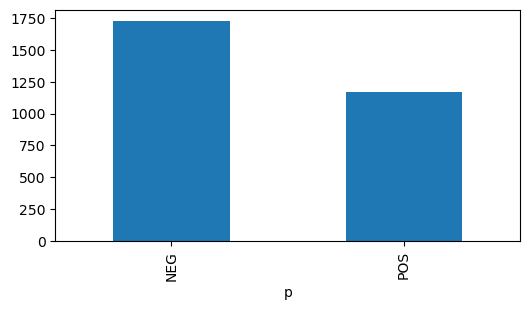

In [9]:
plt.figure(figsize = (6,3))
df['p'].value_counts().plot.bar()

Число текстов, состоящих из более чем одного предложения:

In [10]:
count = 0
for elem in data:
    text = elem['text']
    if '\n' in text or '.' in text[:-1]:
        count+=1
print(count)

85


Число текстов с множественными мнениями:

In [11]:
textcount = Counter(df['text'].value_counts())
textcount

Counter({1: 769,
         2: 391,
         3: 169,
         4: 90,
         5: 37,
         6: 14,
         7: 12,
         8: 4,
         12: 2,
         10: 2,
         23: 1,
         14: 1,
         11: 1,
         9: 1})

<BarContainer object of 14 artists>

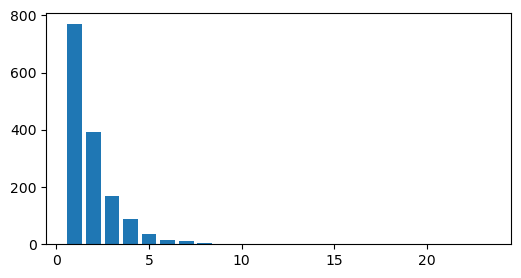

In [12]:
plt.figure(figsize = (6,3))
plt.bar(textcount.keys(), textcount.values())

Число текстов с более чем одним мнением:

In [13]:
sum(textcount.values())-textcount[1]

725

Максимальная и средняя длина, source/holder, target, expression:

In [14]:
sources = list()
for item in df['s']:
    if isinstance(item, str):
        sources.append(item)
    else:
        sources+=item
max_s = max([len(x.split()) for x in sources])
mean_s = sum([len(x.split()) for x in sources])/len(sources)
print(f'Максимальная длина: {max_s}')
print(f'Средняя длина: {mean_s:.3f}')

Максимальная длина: 7
Средняя длина: 1.372


In [15]:
for item in df['s']:
    if isinstance(item, str) and len(item.split()) == max_s:
        print(f'Самый длиный source:\n{item}')

Самый длиный source:
Революционные вооружённые силы Колумбии — Армия народа
Самый длиный source:
мировой судебный участок 363 Хамовнического района Москвы


In [16]:
targets = list()
for item in df['t']:
    if isinstance(item, str):
        targets.append(item)
    else:
        targets+=item
max_t = max([len(x.split()) for x in targets])
mean_t = sum([len(x.split()) for x in targets])/len(targets)
print(f'Максимальная длина: {max_t}')
print(f'Средняя длина: {mean_t:.3f}')

Максимальная длина: 12
Средняя длина: 1.499


In [17]:
for item in df['t']:
    if isinstance(item, str) and len(item.split()) == max_t:
        print(f'Самый длиный target:\n{item}')

Самый длиный target:
Акционерным коммерческим банком содействия благотворительности и духовному развитию Отечества ПЕРЕСВЕТ Акционерное общество


In [18]:
expressions = list()
for item in df['e']:
    if isinstance(item, str):
        expressions.append(item)
    else:
        expressions+=item
max_e = max([len(x.split()) for x in expressions])
mean_e = sum([len(x.split()) for x in expressions])/len(expressions)
print(f'Максимальная длина: {max_e}')
print(f'Средняя длина: {mean_e:.3f}')

Максимальная длина: 18
Средняя длина: 2.562


In [19]:
for item in df['e']:
    if isinstance(item, str) and len(item.split()) == max_e:
        print(f'Самая длиная expression:\n{item}')

Самая длиная expression:
заговоре с целью организации взрывов в нью-йоркском метро и совершения терактов в городах Великобритании и других европейских стран


Самые частые sources:

In [20]:
df['s'].value_counts()

s
NULL              897
AUTHOR            384
США                28
Трамп              15
Владимир Путин     14
                 ... 
Эрик                1
Time                1
Гарсии              1
Гарсия              1
Джибути             1
Name: count, Length: 910, dtype: int64

In [21]:
df['s'].value_counts().sum()

2904

Разрывные/множественные source, target, expression:

In [22]:
s, t, e = 0, 0, 0
for i, row in df.iterrows():
    if isinstance(row['s'], list):
        s+=1
    if isinstance(row['t'], list):
        t+=1
    if isinstance(row['e'], list):
        e+=1

print(f'Multiple/split source: {s}')
print(f'Multiple/split target: {t}')
print(f'Multiple/split expressions: {e}')

Multiple/split source: 0
Multiple/split target: 4
Multiple/split expressions: 19


Примеры:

In [23]:
for i, row in df.iterrows():
    if isinstance(row['e'], list):
        print(row['e'], row['e_span'], sep = '\n')

['снял', 'ограничения на реализацию']
['28:32', '125:150']
['понизило', 'рейтинг']
['102:110', '134:141']
['крупные заемщики', 'имеют некоторые признаки аффилированности друг с другом либо с акционерами или менеджментом банка']
['94:110', '124:221']
['выпускники', 'становятся участниками ДТП']
['132:142', '196:222']
['имеет', 'необходимую поддержку']
['26:31', '48:69']
['имеет', 'необходимую поддержку']
['26:31', '48:69']
['На пост', 'готовят']
['0:7', '63:70']
['В Словакию', 'отправиться']
['0:10', '37:48']
['разрушившим', 'экономику']
['177:188', '211:220']
['контакты', 'приостановлены']
['30:38', '56:70']
['стала', 'донором']
['101:106', '110:117']
['Ситуация', 'остаётся нестабильной']
['0:8', '23:44']
['Желаю', 'здоровья']
['306:311', '333:341']
['играл', 'за']
['32:37', '51:53']
['лишить', 'мандата']
['171:177', '189:196']
['выиграл', 'чемпионский титул']
['29:36', '49:66']
['причастности', 'к убийству']
['59:71', '79:89']
['устраивали праздничные мероприятия', 'после смерти барон

Миинимальная, максимальная, средняя длина текста

In [24]:
lens = [len(x['text'].split()) for x in data]

max_l, min_l, mean_l = max(lens), min(lens), sum(lens)/len(lens)

print(f'Минимальная длина текста: {min_l}')
print(f'Максимальная длина текста: {max_l}')
print(f'Средняя длина текста: {mean_l:.3f}')

Минимальная длина текста: 5
Максимальная длина текста: 201
Средняя длина текста: 18.059


Самый длинный текст

In [25]:
for elem in data:
    if len(elem['text'].split()) == max_l:
        print(elem['sent_id'])
        print(elem['text'])

2047
Макеенко распространил следующее жёсткое видеообращение к Президенту Украины Виктору Януковичу: Я Владимир Макеенко обращаюсь лично к Вам господин Президент и к руководителям силовых структур События происходящие сегодня в столице Украины это трагедия всего украинского народа Я ответственно сообщаю что готов сделать все возможное для прекращения братоубийства и кровопролития в сердце Украины на Майдане Независимости Человеческая жизнь должна быть высшей ценностью в нашем государстве и ничто не может противоречить этому принципу В подтверждение своих слов я принял решение выйти из рядов Партии регионов и принять личную ответственность за жизнедеятельность города Киева Так сложилась моя судьба что в это тяжелое время на меня возложена огромная ответственность за каждого киевлянина Мы должны руководствоваться только интересами народа это единственный шанс сохранить жизнь людей Никакая власть не стоит человеческих жертв Ни один олигарх не погиб ни один политик не погиб я как руководит

Распределение

<BarContainer object of 64 artists>

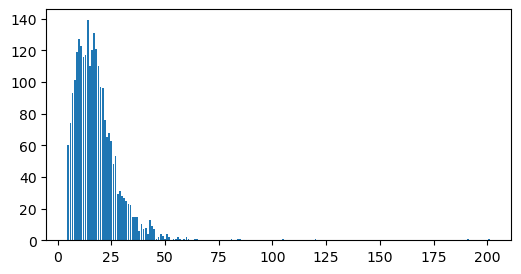

In [26]:
len_counts = Counter(lens)
plt.figure(figsize = (6,3))
plt.bar(len_counts.keys(), len_counts.values())

посмотрим на короткие тексты

In [27]:
for elem in data:
    if len(elem['text'].split()) < 7:
        print(elem['text'])

Фото: Reuters Фото: Reuters Фото: Reuters
Нургалиев уволил начальника УВД Томской области
Президенту Бразилии Дилме Руссефф грозит импичмент
Тилль Линдеманн с огнемётом на сцене.
Дизайнеру ИГИЛ предъявлены обвинения в Индии
У Хиллари Клинтон диагностировали пневмонию
Здоровье Хиллари вызывает всё больше вопросов.
Милицию предлагается переименовать в полицию
Фёдор Емельяненко в 2012 году
Дарио Фо в 1985 году
Тогда Рено было 54 года.
В Тамбове построят центр ядерной медицины.
"Деньги на оборудование выделило "Роснано".
Причина затягивания кризиса - президент.
Чехия остается страной Центральной Европы.
Президент Земан сейчас не левый политик.
Дэвид Рокфеллер 24 октября 1953 года
Владимир Этуш в 2008 году
Владимир Этуш в 1943 году
Владимир Путин в Владимир Этуш
Об этом сообщается на сайте Кремля.
Леннон умер по дороге в больницу.
Дональд Трамп помиловал Джо Арпайо
Ребёнка доставили в ожоговый центр.
Взорвавшийся автомобиль «Тойота Камри» полностью уничтожен.
Ли - особо примечательная лично

## Сохраняем ##

In [28]:
df.to_csv('opinions.csv', index = False)

In [29]:
df1 = df.replace('NULL', 'NULL1')
df1

,sent_id,text,s,t,e,p,s_span,t_span,e_span
0,0,Президент Башкирии Муртаза Рахимов в очередной...,Муртаза Рахимов,главу своей администрации,поменять,NEG,19:34,66:91,57:65
1,1,"Вчера он уволил Азамата Сагитова, который возг...",NULL1,Азамата Сагитова,уволил,NEG,0:0,16:32,9:15
2,3,"Как сообщил ""Ъ"" глава пресс-службы башкирского...",Муртаза Рахимов,главы своей администрации,отставке,NEG,83:98,125:150,116:124
3,5,Этому назначению предшествовал громкий скандал...,NULL1,Радия Хабирова,громкий скандал,NEG,0:0,109:123,31:46
4,6,Год назад в защиту опального башкирского чинов...,Единая Россия,Хабирова,защиту,POS,70:83,111:119,12:18
...,...,...,...,...,...,...,...,...,...
2899,2553,"По его словам, он весьма тронут тёплым приёмом...",NULL1,медиков,профессиональной помощью,POS,0:0,84:91,49:73
2900,2554,"Пациент отметил, что здравоохранение Джибути н...",NULL1,Джибути,на низком уровне,NEG,0:0,37:44,55:71
2901,2555,"Кроме того, военные обеих стран проведут совме...",Гуан Байлин,Джибути,укрепления дружбы,POS,103:114,139:146,68:85
2902,2555,"Кроме того, военные обеих стран проведут совме...",Джибути,Гуан Байлин,укрепления дружбы,POS,139:146,103:114,68:85


In [30]:
df1.to_csv('opinions1.csv', index = False)

In [31]:
test = pd.read_csv('opinions.csv')
test.head()

,sent_id,text,s,t,e,p,s_span,t_span,e_span
0,0,Президент Башкирии Муртаза Рахимов в очередной...,Муртаза Рахимов,главу своей администрации,поменять,NEG,19:34,66:91,57:65
1,1,"Вчера он уволил Азамата Сагитова, который возг...",NaN,Азамата Сагитова,уволил,NEG,0:0,16:32,9:15
2,3,"Как сообщил ""Ъ"" глава пресс-службы башкирского...",Муртаза Рахимов,главы своей администрации,отставке,NEG,83:98,125:150,116:124
3,5,Этому назначению предшествовал громкий скандал...,NaN,Радия Хабирова,громкий скандал,NEG,0:0,109:123,31:46
4,6,Год назад в защиту опального башкирского чинов...,Единая Россия,Хабирова,защиту,POS,70:83,111:119,12:18


In [32]:
test1 = pd.read_csv('opinions1.csv')
test1.head()

,sent_id,text,s,t,e,p,s_span,t_span,e_span
0,0,Президент Башкирии Муртаза Рахимов в очередной...,Муртаза Рахимов,главу своей администрации,поменять,NEG,19:34,66:91,57:65
1,1,"Вчера он уволил Азамата Сагитова, который возг...",NULL1,Азамата Сагитова,уволил,NEG,0:0,16:32,9:15
2,3,"Как сообщил ""Ъ"" глава пресс-службы башкирского...",Муртаза Рахимов,главы своей администрации,отставке,NEG,83:98,125:150,116:124
3,5,Этому назначению предшествовал громкий скандал...,NULL1,Радия Хабирова,громкий скандал,NEG,0:0,109:123,31:46
4,6,Год назад в защиту опального башкирского чинов...,Единая Россия,Хабирова,защиту,POS,70:83,111:119,12:18


In [33]:
len(test.dropna()), len(test1.dropna())

(1623, 2904)